# NTM implementation

This implementation draws heavily from this one found on GitHub : https://github.com/flomlo/ntm_keras

In [137]:
import keras
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, TimeDistributed, Recurrent
from keras.optimizers import RMSprop, Adam
from keras.callbacks import TerminateOnNaN, EarlyStopping
from keras.initializers import RandomNormal, Orthogonal, Zeros, Constant
from keras.activations import softmax, tanh, sigmoid, hard_sigmoid, relu
from keras.engine.topology import InputSpec
from matplotlib import pyplot as plt

In [138]:
def _circulant(leng, n_shifts):
    
    #Original comment from the code we found.
    """
    This will generate a tensor with `n_shifts` of rotated versions the
    identity matrix. When this tensor is multiplied by a vector
    the result are `n_shifts` shifted versions of that vector. Since
    everything is done with inner products, everything is differentiable.
    Paramters:
    ----------
    leng: int > 0, number of memory locations
    n_shifts: int > 0, number of allowed shifts (if 1, no shift)
    Returns:
    --------
    shift operation, a tensor with dimensions (n_shifts, leng, leng)
    """
    eye = np.eye(leng)
    shifts = range(n_shifts//2, -n_shifts//2, -1)
    C = np.asarray([np.roll(eye, s, axis=1) for s in shifts])
    return K.variable(C.astype(K.floatx()))


def _renorm(x):
    return x / (K.sum(x, axis=1, keepdims=True))


def _cosine_distance(M, k):
    nk = K.l2_normalize(k, axis=-1)
    nM = K.l2_normalize(M, axis=-1)
    cosine_distance = K.batch_dot(nM, nk)
    return cosine_distance

def _controller_read_head_emitting_dim(m_depth, shift_range):
    return (m_depth + 1 + 1 + shift_range + 1)

def _controller_write_head_emitting_dim(m_depth, shift_range):
    controller_read_head_emitting_dim = _controller_read_head_emitting_dim(m_depth, shift_range)
    # 2*m because it emits an add and erase vector
    return controller_read_head_emitting_dim + 2*m_depth

def controller_input_output_shape(input_dim, output_dim, m_depth, n_slots, shift_range, read_heads, write_heads):
    controller_read_head_emitting_dim = _controller_read_head_emitting_dim(m_depth, shift_range)
    controller_write_head_emitting_dim = _controller_write_head_emitting_dim(m_depth, shift_range)
    controller_output_dim = (output_dim + read_heads * controller_read_head_emitting_dim + 
                             write_heads * controller_write_head_emitting_dim)
   
    controller_input_dim = input_dim + read_heads * m_depth
    return controller_input_dim, controller_output_dim


class NeuralTuringMachine(Recurrent):
    
    def __init__(self, units, 
                        n_slots=50,
                        m_depth=20,
                        shift_range=3,
                        controller_model=None,
                        read_heads=1,
                        write_heads=1,
                        batch_size=777,                 
                        stateful=False,
                        **kwargs):
        self.output_dim = units
        self.units = units
        self.n_slots = n_slots
        self.m_depth = m_depth
        self.shift_range = shift_range
        self.controller = controller_model
        self.read_heads = read_heads
        self.write_heads = write_heads
        self.batch_size = batch_size
        
        try:
            if controller.state.stateful:
                self.controller_with_state = True 
        except:
            self.controller_with_state = False

        self.ws_read = []
        self.ws_write = []
        self.controller_read_head_emitting_dim = _controller_read_head_emitting_dim(m_depth, shift_range)
        self.controller_write_head_emitting_dim = _controller_write_head_emitting_dim(m_depth, shift_range)

        super(NeuralTuringMachine, self).__init__(**kwargs)
  

    def build(self, input_shape):
        bs, input_length, input_dim = input_shape
        self.controller_input_dim, self.controller_output_dim = controller_input_output_shape(
                input_dim, self.units, self.m_depth, self.n_slots, self.shift_range, self.read_heads,
                self.write_heads)
            
        self.C = _circulant(self.n_slots, self.shift_range)

        self.trainable_weights = self.controller.trainable_weights 

        # We need to declare the number of states we want to carry around.
        # see self.get_initial_states, those respond to:
        # [old_ntm_output] + [init_M, init_wr, init_ww] +  [init_h] + [(init_c] (LSTM only))
        # WARNING: What self.state_spec does is only poorly understood,
        # I only copied it from keras/recurrent.py.
        self.states = [None, None, None, None]
        self.state_spec = [InputSpec(shape=(None, self.output_dim)),                            # old_ntm_output
                            InputSpec(shape=(None, self.n_slots, self.m_depth)),                # Memory
                            InputSpec(shape=(None, self.read_heads, self.n_slots)),   # weights_read
                            InputSpec(shape=(None, self.write_heads, self.n_slots))]  # weights_write

        super(NeuralTuringMachine, self).build(input_shape)


    def get_initial_state(self, X):
        init_old_ntm_output = K.ones((self.batch_size, self.output_dim), name="init_old_ntm_output")*0.42 
        init_M = K.ones((self.batch_size, self.n_slots , self.m_depth), name='main_memory')*0.042
        init_wr = np.zeros((self.batch_size, self.read_heads, self.n_slots))
        init_wr[:,:,0] = 1
        init_wr = K.variable(init_wr, name="init_weights_read")
        init_ww = np.zeros((self.batch_size, self.write_heads, self.n_slots))
        init_ww[:,:,0] = 1
        init_ww = K.variable(init_ww, name="init_weights_write")
        return [init_old_ntm_output, init_M, init_wr, init_ww]

    def _read_from_memory(self, weights, M):
        return K.sum((weights[:, :, None]*M),axis=1)

    def _write_to_memory_erase(self, M, w, e):
        M_tilda = M * (1 - w[:, :, None]*e[:, None, :])
        return M_tilda

    def _write_to_memory_add(self, M_tilda, w, a):
        M_out = M_tilda + w[:, :, None]*a[:, None, :]
        return M_out

    def _get_weight_vector(self, M, w_tm1, k, beta, g, s, gamma):
        # Content adressing
        num = beta * _cosine_distance(M, k)
        w_c  = K.softmax(num) 
        
        # Location adressing
        w_g = (g * w_c) + (1-g)*w_tm1
        
        # C_s is the circular convolution
        C_s = K.sum(K.repeat_elements(self.C[None, :, :, :], self.batch_size, axis=0) * s[:,:,None,None], axis=1)
        w_tilda = K.batch_dot(C_s, w_g)
       
        # sharpening
        w_out = _renorm(w_tilda ** gamma)

        return w_out

    def _run_controller(self, inputs, read_vector):
        controller_input = K.concatenate([inputs, read_vector])
        if self.controller_with_state or len(self.controller.input_shape) == 3:
            controller_input = controller_input[:,None,:]
            controller_output = self.controller.call(controller_input)
            if self.controller.output_shape == 3:
                controller_output = controller_output[:,0,:]
        else:
                controller_output = self.controller.call(controller_input)

        return controller_output

    def _split_and_apply_activations(self, controller_output):
        """ This takes the controller output, splits it in ntm_output, read and wright adressing data.
            It returns a triple of ntm_output, controller_instructions_read, controller_instructions_write.
            ntm_output is a tensor, controller_instructions_read and controller_instructions_write are lists containing
            the adressing instruction (k, beta, g, shift, gamma) and in case of write also the writing constructions,
            consisting of an erase and an add vector. 
            As it is necesseary for stable results,
            k and add_vector is activated via tanh, erase_vector via sigmoid,
            shift via softmax,
            gamma is 1+relu,
            g is sigmoided,
            beta is relu """
        
        # splitting
        ntm_output, controller_instructions_read, controller_instructions_write = tf.split(
                    controller_output,
                    np.asarray([self.output_dim,
                                self.read_heads * self.controller_read_head_emitting_dim,
                                self.write_heads * self.controller_write_head_emitting_dim]),
                    axis=1)

        controller_instructions_read = tf.split(controller_instructions_read, self.read_heads, axis=1)
        controller_instructions_write = tf.split(controller_instructions_write, self.write_heads, axis=1)

        controller_instructions_read = [
                tf.split(single_head_data, np.asarray([self.m_depth, 1, 1, 3, 1]), axis=1) for 
                single_head_data in controller_instructions_read]
        
        controller_instructions_write = [
                tf.split(single_head_data, np.asarray([self.m_depth, 1, 1, 3, 1, self.m_depth, self.m_depth]), axis=1) for 
                single_head_data in controller_instructions_write]
        
        #activation
        ntm_output = sigmoid(ntm_output)
        controller_instructions_read = [(tanh(k), relu(beta), sigmoid(g), softmax(shift), 1 + relu(gamma)) for
                (k, beta, g, shift, gamma) in controller_instructions_read]
        controller_instructions_write = [
                (tanh(k), relu(beta), sigmoid(g), softmax(shift), 1 + relu(gamma), sigmoid(erase_vector), tanh(add_vector))  for 
                (k, beta, g, shift, gamma, erase_vector, add_vector) in controller_instructions_write]
      
        return (ntm_output, controller_instructions_read, controller_instructions_write)
        


    @property
    def output_shape(self):
        input_shape = self.input_shape
        if self.return_sequences:
            return input_shape[0], input_shape[1], self.output_dim
        else:
            return input_shape[0], self.output_dim


    def step(self, layer_input, states):
        _, M, weights_read_tm1, weights_write_tm1 = states[:4]

        weights_read_tm1 = K.reshape(weights_read_tm1,(self.batch_size, self.read_heads, self.n_slots))
        weights_write_tm1 = K.reshape(weights_write_tm1,(self.batch_size, self.write_heads, self.n_slots))

        memory_read_input = K.concatenate([self._read_from_memory(weights_read_tm1[:,i], M) for 
                                           i in range(self.read_heads)])

        # Now feed the controller and let it run a single step
        controller_output = self._run_controller(layer_input, memory_read_input)
        
        # We take the big chunk of unactivated controller output and subdivide it into actual output, reading and
        # writing instructions. Also specific activions for each parameter are applied.
        ntm_output, controller_instructions_read, controller_instructions_write = \
        self._split_and_apply_activations(controller_output)
        

        # addressing:
        weights_write = []
        for i in range(self.write_heads):
            write_head = controller_instructions_write[i]
            old_weight_vector = weights_write_tm1[:,i]
            weight_vector = self._get_weight_vector(M, old_weight_vector, *tuple(write_head[:5]))
            weights_write.append(weight_vector)
            
        # erasing:
        for i in range(self.write_heads):
            M = self._write_to_memory_erase(M, weights_write[i], controller_instructions_write[i][5])
            
        # adding:
        for i in range(self.write_heads):
            M = self._write_to_memory_add(M, weights_write[i], controller_instructions_write[i][6])

        #Calculate the read weights we save in the state and use next ruond.
        weights_read = []
        for i in range(self.read_heads):
            read_head = controller_instructions_read[i]
            old_weight_vector = weights_read_tm1[:,i]
            weight_vector = self._get_weight_vector(M, old_weight_vector, *read_head)
            weights_read.append(weight_vector)
            
        return ntm_output, [ntm_output, M, K.stack(weights_read, axis=1), K.stack(weights_write, axis=1)] 

In [139]:
def gen_model(input_dim, 
              batch_size, 
              output_dim,
              n_slots,
              m_depth,
              controller_model=None,
              read_heads = 1,
              write_heads = 1):

    model = Sequential()
    model.batch_size = batch_size
    model.input_dim = input_dim
    model.output_dim = output_dim

    ntm = NeuralTuringMachine(output_dim, n_slots=n_slots, m_depth=m_depth, shift_range=3,
              controller_model=controller_model,
              read_heads = read_heads,
              write_heads = write_heads,
              return_sequences=True,
              input_shape=(None, input_dim), 
              batch_size = batch_size)
    model.add(ntm)

    optimizer = RMSprop(lr=lr, clipnorm=clipnorm)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['binary_accuracy'], sample_weight_mode="temporal")

    return model


In [140]:
def data_generator(batch_size=100,
                   element_length=8, 
                   min_sequence_length = 1, 
                   max_sequence_length = 20):
    
    end_flag = np.zeros((1, element_length + 1))
    end_flag[0, element_length] = 1
    while True:
        batch_input = np.ones((batch_size, max_sequence_length*2 +1, element_length + 1))*0.5
        batch_output = np.ones((batch_size, max_sequence_length*2 +1, element_length))*0.5
        
        sample_weight  = np.ones((batch_size, max_sequence_length*2 +1))*0.01
        
        for i in range(batch_size):
            random_seq_length = np.random.randint(low=min_sequence_length, high = max_sequence_length+1)
            output_sequence = np.random.binomial(1, 0.5, (random_seq_length, element_length))
            input_sequence = np.zeros((random_seq_length, element_length + 1))
            input_sequence[:,:-1] = output_sequence
            input_sequence = np.concatenate((input_sequence, end_flag), axis=0)
            batch_input[i,:random_seq_length+1,:] = input_sequence
            batch_output[i,random_seq_length+1:random_seq_length*2+1,:] = output_sequence   
            sample_weight[i, random_seq_length+1 :random_seq_length+1+random_seq_length] = 1
        yield batch_input, batch_output, sample_weight

In [141]:
def train_model(model, epochs=100, min_sequence_length=1, max_sequence_length=20, callbacks=None):
    output_dim = model.output_dim
    batch_size = model.batch_size

    generator = data_generator(batch_size=batch_size,
                                    element_length=8, 
                                    min_sequence_length=min_sequence_length,
                                    max_sequence_length=max_sequence_length)
    
    history = model.fit_generator(generator, steps_per_epoch=10, epochs=epochs, callbacks=callbacks, verbose=1)
    return history

In [179]:
def test_model_acc(model):
    output_dim = model.output_dim
    batch_size = model.batch_size
    acc = []
    sequence_lengths=[i for i in range(0, 110, 10)]
    for seq_length in sequence_lengths:
        inp, outp, sw = next(data_generator(min_sequence_length = seq_length, max_sequence_length = seq_length))
        prediction = np.asarray(model.predict(inp, batch_size=batch_size))
        if not np.isnan(prediction.sum()): #checks for a NaN anywhere
            prediction = (prediction > 0.5).astype('float64')
            temp = outp[:, -seq_length:, :] == prediction[:, -seq_length:, :]
            acc.append(temp.mean() * 100)
    return acc

In [160]:
def test_model_loss(model):
    output_dim = model.output_dim
    batch_size = model.batch_size
    loss = []
    sequence_lengths=[i for i in range(0, 110, 10)]
    for seq_length in sequence_lengths:
        inp, outp, _ = next(data_generator(min_sequence_length = seq_length, max_sequence_length = seq_length))
        loss.append(model.evaluate(inp,outp,batch_size=model.batch_size, verbose=0)[0])
    return loss

## Simple LSTM (baseline)

In [144]:
epochs = 100
lr = 5e-4
clipnorm = 10
optimizer = Adam(lr=lr, clipnorm=clipnorm)
hidden_layer_size = 100
batch_size = 100
input_dim = 9
output_dim = 8

model_baseline = Sequential()
model_baseline.output_dim = output_dim
model_baseline.batch_size = batch_size
model_baseline.input_dim = input_dim
model_baseline.add(LSTM(units=hidden_layer_size,
                        #stateful=True,
                        return_sequences=True,
                        batch_input_shape=(batch_size,None,input_dim)))
model_baseline.add(Dense(units=output_dim,
                        activation='sigmoid'))

model_baseline.compile(loss='binary_crossentropy', optimizer=optimizer, 
                       metrics = ['binary_accuracy'],sample_weight_mode="temporal")

model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (100, None, 100)          44000     
_________________________________________________________________
dense_30 (Dense)             (100, None, 8)            808       
Total params: 44,808
Trainable params: 44,808
Non-trainable params: 0
_________________________________________________________________


## NTM with LSTM controller

In [146]:
controller_type = 'LSTM'
epochs = 100
lr = 5e-4
clipnorm = 10
optimizer = Adam(lr=lr, clipnorm=clipnorm)
m_depth = 20
n_slots = 128
read_heads = 1
write_heads = 1
hidden_layer_size = 100
batch_size = 100
input_dim = 9
output_dim = 8
shift_range = 3

controller_input_dim, controller_output_dim = controller_input_output_shape(input_dim=input_dim, 
                                                                            output_dim=output_dim, 
                                                                            m_depth=m_depth, 
                                                                            n_slots=n_slots, 
                                                                            shift_range=shift_range, 
                                                                            read_heads=read_heads,
                                                                            write_heads=write_heads)
controller_LSTM = Sequential()


controller_LSTM.add(LSTM(units=hidden_layer_size,
                         stateful=True,
                         kernel_initializer='random_normal', 
                         bias_initializer='random_normal',
                         activation='linear',
                         batch_input_shape=(batch_size, None, controller_input_dim)))
controller_LSTM.add(Dense(units=controller_output_dim,
                          kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          activation='linear'))

controller_LSTM.compile(loss='binary_crossentropy', optimizer=optimizer, 
                        metrics = ['binary_accuracy'], sample_weight_mode="temporal")
    
    
NTM_LSTM = gen_model(input_dim = input_dim, 
                    output_dim=output_dim, 
                  batch_size=batch_size,
                  n_slots=n_slots,
                  m_depth=m_depth,
                  controller_model=controller_LSTM, 
                  read_heads=read_heads, 
                  write_heads=write_heads)
                  

controller_LSTM.summary()
NTM_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (100, 100)                52000     
_________________________________________________________________
dense_31 (Dense)             (100, 100)                10100     
Total params: 62,100
Trainable params: 62,100
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_turing_machine_13 (Ne (None, None, 8)           62100     
Total params: 62,100
Trainable params: 62,100
Non-trainable params: 0
_________________________________________________________________


## NTM with FeedForward controller

In [147]:
controller_type = 'FeedForward'
epochs = 100
lr = 5e-4
clipnorm = 10
optimizer = Adam(lr=lr, clipnorm=clipnorm)
m_depth = 20
n_slots = 128
read_heads = 1
write_heads = 1
hidden_layer_size = 100
batch_size = 100
input_dim = 9
output_dim = 8
shift_range = 3

controller_input_dim, controller_output_dim = controller_input_output_shape(input_dim=input_dim, 
                                                                            output_dim=output_dim, 
                                                                            m_depth=m_depth, 
                                                                            n_slots=n_slots, 
                                                                            shift_range=shift_range, 
                                                                            read_heads=read_heads,
                                                                            write_heads=write_heads)
controller_FFW = Sequential()


controller_FFW.add(Dense(units=hidden_layer_size,
                         activation='linear',
                         kernel_initializer='random_normal',
                         bias_initializer='random_normal',
                         input_dim=controller_input_dim))
controller_FFW.add(Dense(units=controller_output_dim,
                         kernel_initializer='random_normal',
                         bias_initializer='random_normal',
                         activation='linear'))
    
controller_FFW.compile(loss='binary_crossentropy', optimizer=optimizer, 
                       metrics = ['binary_accuracy'], sample_weight_mode="temporal")
    
    
NTM_FFW = gen_model(input_dim=input_dim, 
                  output_dim=output_dim, 
                  batch_size=batch_size,
                  n_slots=n_slots,
                  m_depth=m_depth,
                  controller_model=controller_FFW, 
                  read_heads=read_heads, 
                  write_heads=write_heads)

NTM_FFW.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_turing_machine_14 (Ne (None, None, 8)           13100     
Total params: 13,100
Trainable params: 13,100
Non-trainable params: 0
_________________________________________________________________


## Models training

In [148]:
history_baseline = train_model(model_baseline, epochs = 500, callbacks=[TerminateOnNaN()])

Epoch 1/500
10/10 [==============================] - 3s 253ms/step - loss: 0.1869 - binary_accuracy: 0.1315
Epoch 2/500
10/10 [==============================] - 0s 32ms/step - loss: 0.1797 - binary_accuracy: 0.1296
Epoch 3/500
10/10 [==============================] - 0s 32ms/step - loss: 0.1776 - binary_accuracy: 0.1297
Epoch 4/500
10/10 [==============================] - 0s 31ms/step - loss: 0.1804 - binary_accuracy: 0.1334
Epoch 5/500
10/10 [==============================] - 0s 32ms/step - loss: 0.1843 - binary_accuracy: 0.1410
Epoch 6/500
10/10 [==============================] - 0s 32ms/step - loss: 0.1817 - binary_accuracy: 0.1434
Epoch 7/500
10/10 [==============================] - 0s 31ms/step - loss: 0.1854 - binary_accuracy: 0.1502
Epoch 8/500
10/10 [==============================] - 0s 32ms/step - loss: 0.1778 - binary_accuracy: 0.1488
Epoch 9/500
10/10 [==============================] - 0s 32ms/step - loss: 0.1765 - binary_accuracy: 0.1509
Epoch 10/500
10/10 [================

10/10 [==============================] - 0s 28ms/step - loss: 0.1537 - binary_accuracy: 0.1732
Epoch 152/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1544 - binary_accuracy: 0.1738
Epoch 153/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1586 - binary_accuracy: 0.1784
Epoch 154/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1557 - binary_accuracy: 0.1753
Epoch 155/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1568 - binary_accuracy: 0.1784
Epoch 156/500
10/10 [==============================] - 0s 31ms/step - loss: 0.1555 - binary_accuracy: 0.1771
Epoch 157/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1610 - binary_accuracy: 0.1805
Epoch 158/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1537 - binary_accuracy: 0.1726
Epoch 159/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1568 - binary_accuracy: 0.1777
Epoch 160/500
10/10 [============

10/10 [==============================] - 0s 28ms/step - loss: 0.1435 - binary_accuracy: 0.1846
Epoch 302/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1444 - binary_accuracy: 0.1835
Epoch 303/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1408 - binary_accuracy: 0.1798
Epoch 304/500
10/10 [==============================] - 0s 30ms/step - loss: 0.1399 - binary_accuracy: 0.1793
Epoch 305/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1445 - binary_accuracy: 0.1849
Epoch 306/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1442 - binary_accuracy: 0.1856
Epoch 307/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1423 - binary_accuracy: 0.1841
Epoch 308/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1450 - binary_accuracy: 0.1848
Epoch 309/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1459 - binary_accuracy: 0.1862
Epoch 310/500
10/10 [============

10/10 [==============================] - 0s 28ms/step - loss: 0.1326 - binary_accuracy: 0.1878
Epoch 451/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1320 - binary_accuracy: 0.1870
Epoch 452/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1355 - binary_accuracy: 0.1918
Epoch 453/500
10/10 [==============================] - 0s 30ms/step - loss: 0.1346 - binary_accuracy: 0.1898
Epoch 454/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1293 - binary_accuracy: 0.1861
Epoch 455/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1351 - binary_accuracy: 0.1921
Epoch 456/500
10/10 [==============================] - 0s 29ms/step - loss: 0.1333 - binary_accuracy: 0.1904
Epoch 457/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1395 - binary_accuracy: 0.1967
Epoch 458/500
10/10 [==============================] - 0s 28ms/step - loss: 0.1330 - binary_accuracy: 0.1899
Epoch 459/500
10/10 [============

In [149]:
history_NTM_LSTM = train_model(NTM_LSTM, epochs = 500,callbacks=[TerminateOnNaN()])

Epoch 1/500
10/10 [==============================] - 40s 4s/step - loss: 0.1814 - binary_accuracy: 0.1269
Epoch 2/500
10/10 [==============================] - 37s 4s/step - loss: 0.1808 - binary_accuracy: 0.1269
Epoch 3/500
10/10 [==============================] - 38s 4s/step - loss: 0.1848 - binary_accuracy: 0.1297
Epoch 4/500
10/10 [==============================] - 38s 4s/step - loss: 0.1795 - binary_accuracy: 0.1261
Epoch 5/500
10/10 [==============================] - 39s 4s/step - loss: 0.1767 - binary_accuracy: 0.1237
Epoch 6/500
10/10 [==============================] - 38s 4s/step - loss: 0.1866 - binary_accuracy: 0.1307
Epoch 7/500
10/10 [==============================] - 38s 4s/step - loss: 0.1847 - binary_accuracy: 0.1294
Epoch 8/500
10/10 [==============================] - 37s 4s/step - loss: 0.1787 - binary_accuracy: 0.1257
Epoch 9/500
10/10 [==============================] - 39s 4s/step - loss: 0.1761 - binary_accuracy: 0.1239
Epoch 10/500
10/10 [==========================

10/10 [==============================] - 37s 4s/step - loss: 0.1716 - binary_accuracy: 0.1649
Epoch 154/500
10/10 [==============================] - 37s 4s/step - loss: 0.1719 - binary_accuracy: 0.1649
Epoch 155/500
10/10 [==============================] - 37s 4s/step - loss: 0.1654 - binary_accuracy: 0.1608
Epoch 156/500
10/10 [==============================] - 37s 4s/step - loss: 0.1724 - binary_accuracy: 0.1658
Epoch 157/500
10/10 [==============================] - 37s 4s/step - loss: 0.1611 - binary_accuracy: 0.1594
Epoch 158/500
10/10 [==============================] - 37s 4s/step - loss: 0.1694 - binary_accuracy: 0.1660
Epoch 159/500
10/10 [==============================] - 37s 4s/step - loss: 0.1671 - binary_accuracy: 0.1664
Epoch 160/500
10/10 [==============================] - 37s 4s/step - loss: 0.1694 - binary_accuracy: 0.1673
Epoch 161/500
10/10 [==============================] - 37s 4s/step - loss: 0.1626 - binary_accuracy: 0.1632
Epoch 162/500
10/10 [=====================

Epoch 229/500
10/10 [==============================] - 37s 4s/step - loss: 0.1693 - binary_accuracy: 0.1639
Epoch 230/500
10/10 [==============================] - 37s 4s/step - loss: 0.1378 - binary_accuracy: 0.1884
Epoch 231/500
10/10 [==============================] - 37s 4s/step - loss: 0.1347 - binary_accuracy: 0.1984
Epoch 232/500
10/10 [==============================] - 37s 4s/step - loss: 0.1293 - binary_accuracy: 0.1917
Epoch 233/500
10/10 [==============================] - 37s 4s/step - loss: 0.1373 - binary_accuracy: 0.1909
Epoch 234/500
10/10 [==============================] - 37s 4s/step - loss: 0.1275 - binary_accuracy: 0.2004
Epoch 235/500
10/10 [==============================] - 37s 4s/step - loss: 0.1305 - binary_accuracy: 0.1945
Epoch 236/500
10/10 [==============================] - 37s 4s/step - loss: 0.1275 - binary_accuracy: 0.2001
Epoch 237/500
10/10 [==============================] - 37s 4s/step - loss: 0.1277 - binary_accuracy: 0.2068
Epoch 238/500
10/10 [=======

Epoch 380/500
10/10 [==============================] - 37s 4s/step - loss: 0.0682 - binary_accuracy: 0.2355
Epoch 381/500
10/10 [==============================] - 37s 4s/step - loss: 0.0654 - binary_accuracy: 0.2370
Epoch 382/500
10/10 [==============================] - 37s 4s/step - loss: 0.0642 - binary_accuracy: 0.2367
Epoch 383/500
10/10 [==============================] - 37s 4s/step - loss: 0.0867 - binary_accuracy: 0.2261
Epoch 384/500
10/10 [==============================] - 37s 4s/step - loss: 0.0708 - binary_accuracy: 0.2410
Epoch 385/500
10/10 [==============================] - 37s 4s/step - loss: 0.0614 - binary_accuracy: 0.2328
Epoch 386/500
10/10 [==============================] - 37s 4s/step - loss: 0.0590 - binary_accuracy: 0.2329
Epoch 387/500
10/10 [==============================] - 37s 4s/step - loss: 0.0865 - binary_accuracy: 0.2333
Epoch 388/500
10/10 [==============================] - 37s 4s/step - loss: 0.0883 - binary_accuracy: 0.2243
Epoch 389/500
10/10 [=======

In [150]:
history_NTM_FFW = train_model(NTM_FFW, epochs = 500,callbacks=[TerminateOnNaN()])

Epoch 1/500
10/10 [==============================] - 39s 4s/step - loss: 0.1880 - binary_accuracy: 0.1320
Epoch 2/500
10/10 [==============================] - 36s 4s/step - loss: 0.1811 - binary_accuracy: 0.1269
Epoch 3/500
10/10 [==============================] - 36s 4s/step - loss: 0.1788 - binary_accuracy: 0.1259
Epoch 4/500
10/10 [==============================] - 36s 4s/step - loss: 0.1830 - binary_accuracy: 0.1286
Epoch 5/500
10/10 [==============================] - 36s 4s/step - loss: 0.1846 - binary_accuracy: 0.1295
Epoch 6/500
10/10 [==============================] - 36s 4s/step - loss: 0.1809 - binary_accuracy: 0.1275
Epoch 7/500
10/10 [==============================] - 36s 4s/step - loss: 0.1813 - binary_accuracy: 0.1285
Epoch 8/500
10/10 [==============================] - 35s 4s/step - loss: 0.1816 - binary_accuracy: 0.1314
Epoch 9/500
10/10 [==============================] - 36s 4s/step - loss: 0.1808 - binary_accuracy: 0.1322
Epoch 10/500
10/10 [==========================

10/10 [==============================] - 36s 4s/step - loss: 0.0978 - binary_accuracy: 0.2202
Epoch 154/500
10/10 [==============================] - 36s 4s/step - loss: 0.0902 - binary_accuracy: 0.2144
Epoch 155/500
10/10 [==============================] - 36s 4s/step - loss: 0.0876 - binary_accuracy: 0.2205
Epoch 156/500
10/10 [==============================] - 36s 4s/step - loss: 0.0815 - binary_accuracy: 0.2180
Epoch 157/500
10/10 [==============================] - 36s 4s/step - loss: 0.0913 - binary_accuracy: 0.2216
Epoch 158/500
10/10 [==============================] - 36s 4s/step - loss: 0.0832 - binary_accuracy: 0.2294
Epoch 159/500
10/10 [==============================] - 36s 4s/step - loss: 0.0961 - binary_accuracy: 0.2201
Epoch 160/500
10/10 [==============================] - 36s 4s/step - loss: 0.0807 - binary_accuracy: 0.2227
Epoch 161/500
10/10 [==============================] - 36s 4s/step - loss: 0.0822 - binary_accuracy: 0.2256
Epoch 162/500
10/10 [=====================

Epoch 229/500
10/10 [==============================] - 36s 4s/step - loss: 0.0065 - binary_accuracy: 0.2596
Epoch 230/500
10/10 [==============================] - 36s 4s/step - loss: 0.0066 - binary_accuracy: 0.2584
Epoch 231/500
10/10 [==============================] - 36s 4s/step - loss: 0.0065 - binary_accuracy: 0.2455
Epoch 232/500
10/10 [==============================] - 36s 4s/step - loss: 0.0064 - binary_accuracy: 0.2497
Epoch 233/500
10/10 [==============================] - 36s 4s/step - loss: 0.0064 - binary_accuracy: 0.2554
Epoch 234/500
10/10 [==============================] - 36s 4s/step - loss: 0.0081 - binary_accuracy: 0.2499
Epoch 235/500
10/10 [==============================] - 36s 4s/step - loss: 0.0063 - binary_accuracy: 0.2515
Epoch 236/500
10/10 [==============================] - 36s 4s/step - loss: 0.0079 - binary_accuracy: 0.2533
Epoch 237/500
10/10 [==============================] - 36s 4s/step - loss: 0.0064 - binary_accuracy: 0.2562
Epoch 238/500
10/10 [=======

Epoch 380/500
10/10 [==============================] - 36s 4s/step - loss: 0.0051 - binary_accuracy: 0.2650
Epoch 381/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2534
Epoch 382/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2571
Epoch 383/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2588
Epoch 384/500
10/10 [==============================] - 36s 4s/step - loss: 0.0051 - binary_accuracy: 0.2670
Epoch 385/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2573
Epoch 386/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2510
Epoch 387/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2488
Epoch 388/500
10/10 [==============================] - 36s 4s/step - loss: 0.0052 - binary_accuracy: 0.2524
Epoch 389/500
10/10 [=======

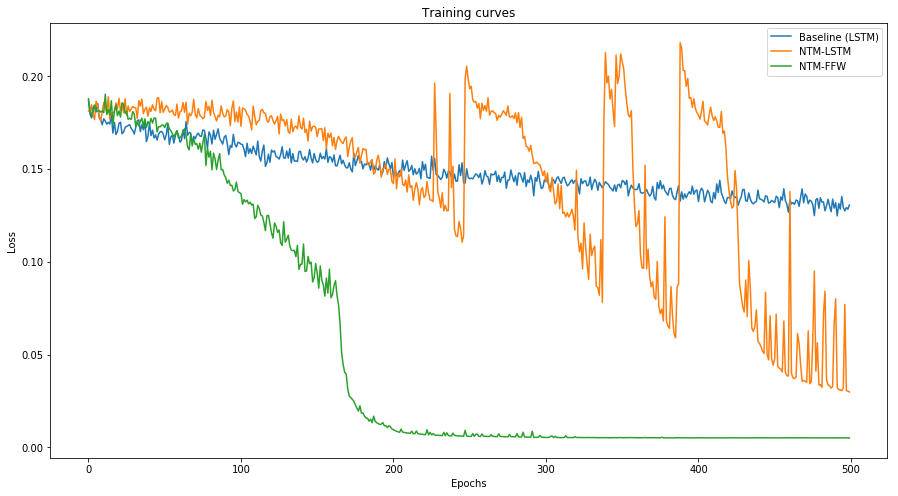

In [151]:
plt.figure(figsize=(15,8))
plt.plot(history_baseline.history['loss'], label="Baseline (LSTM)")
plt.plot(history_NTM_LSTM.history['loss'], label="NTM-LSTM")
plt.plot(history_NTM_FFW.history['loss'], label="NTM-FFW")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training curves")
plt.show()

It seems the NTM with feedforward controller is easier to train and achieve 100% accuracy, the LSTM controller shold also achieve perfect score, but should need longer to train.

## Generalization to longer sequences

According to the paper, NTM with LSTM controller generalizes very well for longer sequences. We should expect also the same results for FeedForward NTM. The baseline should perform poorly on sequence lengths it never saw before.

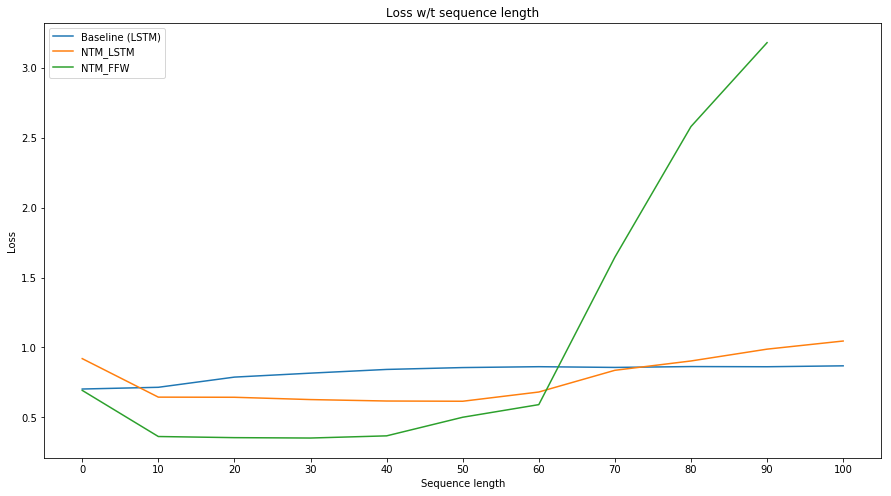

In [161]:
loss_baseline = test_model_loss(model_baseline)
loss_NTM_LSTM = test_model_loss(NTM_LSTM)
loss_NTM_FFW = test_model_loss(NTM_FFW)
sequence_lengths=[i for i in range(0, 110, 10)]
plt.figure(figsize=(15,8))
plt.plot(sequence_lengths, loss_baseline, label="Baseline (LSTM)")
plt.plot(sequence_lengths, loss_NTM_LSTM, label="NTM_LSTM")
plt.plot(sequence_lengths, loss_NTM_FFW, label="NTM_FFW")
plt.legend()
plt.xlabel("Sequence length")
plt.xticks(sequence_lengths)
plt.ylabel("Loss")
plt.title("Loss w/t sequence length")
plt.show()

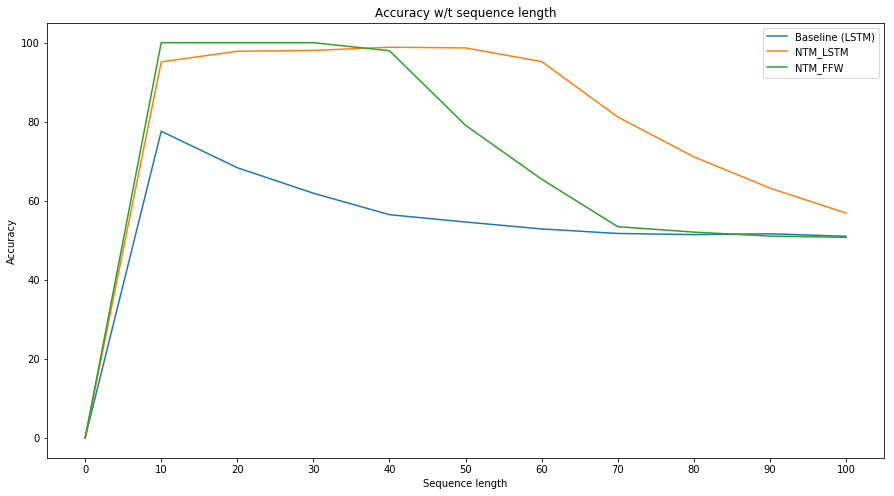

In [180]:
acc_baseline = test_model_acc(model_baseline)
acc_NTM_LSTM = test_model_acc(NTM_LSTM)
acc_NTM_FFW = test_model_acc(NTM_FFW)
plt.figure(figsize=(15,8))
plt.plot(sequence_lengths, acc_baseline, label="Baseline (LSTM)")
plt.plot(sequence_lengths, acc_NTM_LSTM, label="NTM_LSTM")
plt.plot(sequence_lengths, acc_NTM_FFW, label="NTM_FFW")
plt.legend()
plt.xlabel("Sequence length")
plt.xticks(sequence_lengths)
plt.ylabel("Accuracy")
plt.title("Accuracy w/t sequence length")
plt.show()

- 50% accuracy is random output which means the model doesn't know at all what to do. The baseline can't even achieve perfect accuracy on sequence lengths it was trained on and its accuracy deteriorates very quickly for longer sequences.
- both NTM models manage to generalize to longer sequences, LSTM controller being the more robust. To be noted, NTM-FFW achieves 100% accuracy more or less for sequence length up to 40 whereas training was done on sequence length of maximum 20. And LSTM controller goes up to 60 before losing accuracy.

## Visualising the read and write heads/attention (with NTM_LSTM model)

To get access to the read and write weights, we use a small trick. We create a second model with exactly the same structure as before, but now we ask the NTM to output alongside the regular output the read/write weights. We don't need to train this alternative network, we just need to set its trainable parameters with the parameters from a previously trained model. Like that, we can then directly fetch from the output of our alternative model the weights to be plotted. 

In [163]:
class NeuralTuringMachine2(Recurrent):
    
    def __init__(self, units, 
                        n_slots=50,
                        m_depth=20,
                        shift_range=3,
                        controller_model=None,
                        read_heads=1,
                        write_heads=1,
                        batch_size=777,                 
                        stateful=False,
                        **kwargs):
        self.output_dim = units
        self.units = units
        self.n_slots = n_slots
        self.m_depth = m_depth
        self.shift_range = shift_range
        self.controller = controller_model
        self.read_heads = read_heads
        self.write_heads = write_heads
        self.batch_size = batch_size
        self.output_dim_modif = self.output_dim+self.n_slots*self.read_heads+self.n_slots*self.write_heads
        
        try:
            if controller.state.stateful:
                self.controller_with_state = True 
        except:
            self.controller_with_state = False

        self.controller_read_head_emitting_dim = _controller_read_head_emitting_dim(m_depth, shift_range)
        self.controller_write_head_emitting_dim = _controller_write_head_emitting_dim(m_depth, shift_range)

        super(NeuralTuringMachine2, self).__init__(**kwargs)
  

    def build(self, input_shape):
        bs, input_length, input_dim = input_shape
        self.controller_input_dim, self.controller_output_dim = controller_input_output_shape(
                input_dim, self.units, self.m_depth, self.n_slots, self.shift_range, self.read_heads,
                self.write_heads)
            
        self.C = _circulant(self.n_slots, self.shift_range)

        self.trainable_weights = self.controller.trainable_weights 

        # We need to declare the number of states we want to carry around.
        # see self.get_initial_states, those respond to:
        # [old_ntm_output] + [init_M, init_wr, init_ww] +  [init_h] + [(init_c] (LSTM only))
        # WARNING: What self.state_spec does is only poorly understood,
        # I only copied it from keras/recurrent.py.
        self.states = [None, None, None, None]
        self.state_spec = [InputSpec(shape=(None, self.output_dim_modif)),                            # old_ntm_output
                            InputSpec(shape=(None, self.n_slots, self.m_depth)),                # Memory
                            InputSpec(shape=(None, self.read_heads, self.n_slots)),   # weights_read
                            InputSpec(shape=(None, self.write_heads, self.n_slots))]  # weights_write

        super(NeuralTuringMachine2, self).build(input_shape)


    def get_initial_state(self, X):
        init_old_ntm_output = K.ones((self.batch_size, self.output_dim_modif), name="init_old_ntm_output")*0.42 
        init_M = K.ones((self.batch_size, self.n_slots , self.m_depth), name='main_memory')*0.042
        init_wr = np.zeros((self.batch_size, self.read_heads, self.n_slots))
        init_wr[:,:,0] = 1
        init_wr = K.variable(init_wr, name="init_weights_read")
        init_ww = np.zeros((self.batch_size, self.write_heads, self.n_slots))
        init_ww[:,:,0] = 1
        init_ww = K.variable(init_ww, name="init_weights_write")
        return [init_old_ntm_output, init_M, init_wr, init_ww]

    def _read_from_memory(self, weights, M):
        return K.sum((weights[:, :, None]*M),axis=1)

    def _write_to_memory_erase(self, M, w, e):
        M_tilda = M * (1 - w[:, :, None]*e[:, None, :])
        return M_tilda

    def _write_to_memory_add(self, M_tilda, w, a):
        M_out = M_tilda + w[:, :, None]*a[:, None, :]
        return M_out

    def _get_weight_vector(self, M, w_tm1, k, beta, g, s, gamma):
        # Content adressing
        num = beta * _cosine_distance(M, k)
        w_c  = K.softmax(num) 
        
        # Location adressing
        w_g = (g * w_c) + (1-g)*w_tm1
        
        # C_s is the circular convolution
        C_s = K.sum(K.repeat_elements(self.C[None, :, :, :], self.batch_size, axis=0) * s[:,:,None,None], axis=1)
        w_tilda = K.batch_dot(C_s, w_g)
       
        # sharpening
        w_out = _renorm(w_tilda ** gamma)

        return w_out

    def _run_controller(self, inputs, read_vector):
        controller_input = K.concatenate([inputs, read_vector])
        if self.controller_with_state or len(self.controller.input_shape) == 3:
            controller_input = controller_input[:,None,:]
            controller_output = self.controller.call(controller_input)
            if self.controller.output_shape == 3:
                controller_output = controller_output[:,0,:]
        else:
                controller_output = self.controller.call(controller_input)

        return controller_output

    def _split_and_apply_activations(self, controller_output):
        """ This takes the controller output, splits it in ntm_output, read and wright adressing data.
            It returns a triple of ntm_output, controller_instructions_read, controller_instructions_write.
            ntm_output is a tensor, controller_instructions_read and controller_instructions_write are lists containing
            the adressing instruction (k, beta, g, shift, gamma) and in case of write also the writing constructions,
            consisting of an erase and an add vector. 
            As it is necesseary for stable results,
            k and add_vector is activated via tanh, erase_vector via sigmoid,
            shift via softmax,
            gamma is 1+relu,
            g is sigmoided,
            beta is relu """
        
        # splitting
        ntm_output, controller_instructions_read, controller_instructions_write = tf.split(
                    controller_output,
                    np.asarray([self.output_dim,
                                self.read_heads * self.controller_read_head_emitting_dim,
                                self.write_heads * self.controller_write_head_emitting_dim]),
                    axis=1)

        controller_instructions_read = tf.split(controller_instructions_read, self.read_heads, axis=1)
        controller_instructions_write = tf.split(controller_instructions_write, self.write_heads, axis=1)

        controller_instructions_read = [
                tf.split(single_head_data, np.asarray([self.m_depth, 1, 1, 3, 1]), axis=1) for 
                single_head_data in controller_instructions_read]
        
        controller_instructions_write = [
                tf.split(single_head_data, np.asarray([self.m_depth, 1, 1, 3, 1, self.m_depth, self.m_depth]), axis=1) for 
                single_head_data in controller_instructions_write]
        
        #activation
        ntm_output = sigmoid(ntm_output)
        controller_instructions_read = [(tanh(k), relu(beta), sigmoid(g), softmax(shift), 1 + relu(gamma)) for
                (k, beta, g, shift, gamma) in controller_instructions_read]
        controller_instructions_write = [
                (tanh(k), relu(beta), sigmoid(g), softmax(shift), 1 + relu(gamma), sigmoid(erase_vector), tanh(add_vector))  for 
                (k, beta, g, shift, gamma, erase_vector, add_vector) in controller_instructions_write]
      
        return (ntm_output, controller_instructions_read, controller_instructions_write)
        


    @property
    def output_shape(self):
        input_shape = self.input_shape
        if self.return_sequences:
            return input_shape[0], input_shape[1], self.output_dim_modif
        else:
            return input_shape[0], self.output_dim_modif
        

    def step(self, layer_input, states):
        _, M, weights_read_tm1, weights_write_tm1 = states[:4]

        weights_read_tm1 = K.reshape(weights_read_tm1,(self.batch_size, self.read_heads, self.n_slots))
        weights_write_tm1 = K.reshape(weights_write_tm1,(self.batch_size, self.write_heads, self.n_slots))

        memory_read_input = K.concatenate([self._read_from_memory(weights_read_tm1[:,i], M) for 
                                           i in range(self.read_heads)])

        # Now feed the controller and let it run a single step
        controller_output = self._run_controller(layer_input, memory_read_input)
        
        # We take the big chunk of unactivated controller output and subdivide it into actual output, reading and
        # writing instructions. Also specific activions for each parameter are applied.
        ntm_output, controller_instructions_read, controller_instructions_write = \
        self._split_and_apply_activations(controller_output)
        
        
        # addressing:
        weights_write = []
        for i in range(self.write_heads):
            write_head = controller_instructions_write[i]
            old_weight_vector = weights_write_tm1[:,i]
            weight_vector = self._get_weight_vector(M, old_weight_vector, *tuple(write_head[:5]))
            weights_write.append(weight_vector)
            ntm_output = K.concatenate([ntm_output, weight_vector],axis=1)
        
        
        # erasing:
        for i in range(self.write_heads):
            M = self._write_to_memory_erase(M, weights_write[i], controller_instructions_write[i][5])
            
        # adding:
        for i in range(self.write_heads):
            M = self._write_to_memory_add(M, weights_write[i], controller_instructions_write[i][6])

        #Calculate the read weights we save in the state and use next ruond.
        weights_read = []
        for i in range(self.read_heads):
            read_head = controller_instructions_read[i]
            old_weight_vector = weights_read_tm1[:,i]
            weight_vector = self._get_weight_vector(M, old_weight_vector, *read_head)
            weights_read.append(weight_vector)
            ntm_output = K.concatenate([ntm_output, weight_vector],axis=1)
            
        return ntm_output, [ntm_output, M, K.stack(weights_read, axis=1), K.stack(weights_write, axis=1)] 

In [164]:
def gen_model2(input_dim, 
              batch_size, 
              output_dim,
              n_slots,
              m_depth,
              controller_model=None,
              read_heads = 1,
              write_heads = 1):

    model = Sequential()
    model.batch_size = batch_size
    model.input_dim = input_dim
    model.output_dim = output_dim

    ntm = NeuralTuringMachine2(output_dim, n_slots=n_slots, m_depth=m_depth, shift_range=3,
              controller_model=controller_model,
              read_heads = read_heads,
              write_heads = write_heads,
              return_sequences=True,
              input_shape=(None, input_dim), 
              batch_size = batch_size)
    model.add(ntm)

    optimizer = RMSprop(lr=lr, clipnorm=clipnorm)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['binary_accuracy'], sample_weight_mode="temporal")

    return model


In [165]:
controller_type = 'LSTM'
epochs = 100
lr = 1e-4
clipnorm = 10
optimizer = RMSprop(lr=lr, clipnorm=clipnorm)
m_depth = 20
n_slots = 128
read_heads = 1
write_heads = 1
hidden_layer_size = 100
batch_size = 100
input_dim = 9
output_dim = 8
shift_range = 3


controller_copy = Sequential()



#the only trainable weights of the model are the ones from the controller.
#So setting up our alternative network as a trained model is done by 
#setting the weights of the controller as the weights of a previously trained controller

if controller_type == 'LSTM':
    controller_input_dim, controller_output_dim = controller_input_output_shape(input_dim=input_dim, 
                                                                            output_dim=output_dim, 
                                                                            m_depth=m_depth, 
                                                                            n_slots=n_slots, 
                                                                            shift_range=shift_range, 
                                                                            read_heads=read_heads,
                                                                            write_heads=write_heads)
    controller_copy.add(LSTM(units=hidden_layer_size,
                             stateful=True,
                             batch_input_shape=(batch_size, None, controller_input_dim)))
    controller_copy.add(Dense(units=controller_output_dim,
                              activation='linear'))

    controller_copy.compile(loss='binary_crossentropy', optimizer=optimizer, 
                            metrics = ['binary_accuracy'], sample_weight_mode="temporal")
    
    
    for i in range(len(controller_copy.layers)):
        controller_copy.layers[i].set_weights(controller_LSTM.layers[i].get_weights())

elif controller_type == 'FFW' :
    controller_input_dim, controller_output_dim = controller_input_output_shape(input_dim=input_dim, 
                                                                            output_dim=output_dim, 
                                                                            m_depth=m_depth, 
                                                                            n_slots=n_slots, 
                                                                            shift_range=shift_range, 
                                                                            read_heads=read_heads,
                                                                            write_heads=write_heads)
    
    controller_copy.add(Dense(units=hidden_layer_size,
                             activation='linear',
                             input_dim=controller_input_dim))
    controller_copy.add(Dense(units=controller_output_dim,
                             activation='linear'))
    
    controller_copy.compile(loss='binary_crossentropy', optimizer=optimizer, 
                            metrics = ['binary_accuracy'], sample_weight_mode="temporal")
    
    for i in range(len(controller_copy.layers)):
        controller_copy.layers[i].set_weights(controller_FFW.layers[i].get_weights())
    
    
NTM_LSTM2 = gen_model2(input_dim=input_dim, 
                  output_dim=output_dim, 
                  batch_size=batch_size,
                  n_slots=n_slots,
                  m_depth=m_depth,
                  controller_model=controller_copy, 
                  read_heads=read_heads, 
                  write_heads=write_heads)

In [166]:
seq_length = 10

generator = data_generator(element_length=8, 
                           min_sequence_length=seq_length,
                           max_sequence_length=seq_length)
data = next(generator)
aaa=NTM_LSTM2.predict(data[0],batch_size=100,verbose=1);


100/100 [==============================] - 3s 32ms/step


In [167]:
#let's look at the attention weights for the i-th seqence of the batch
temp = np.asarray(aaa[70])
_, write, read = np.split(temp, [8,128+8], axis=1)

In [168]:
write.shape

(21, 128)

## Reads

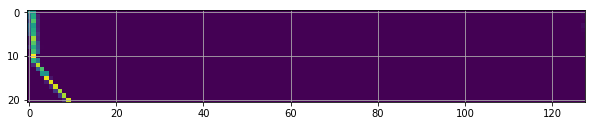

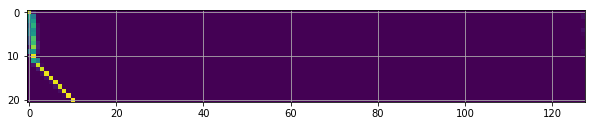

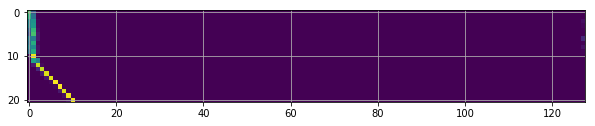

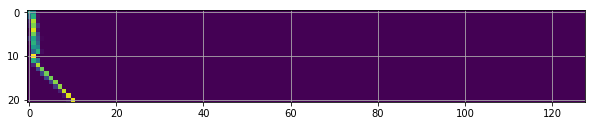

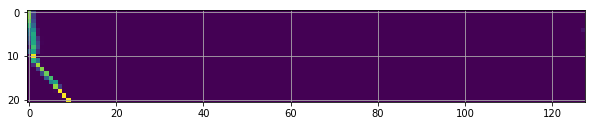

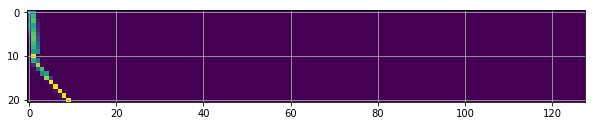

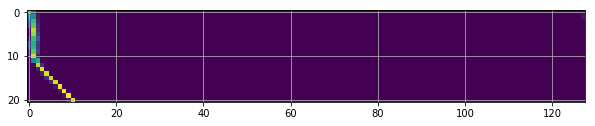

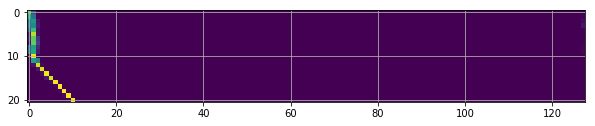

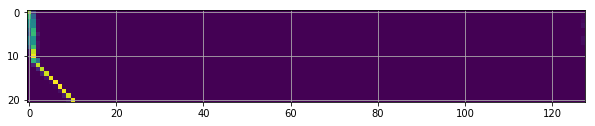

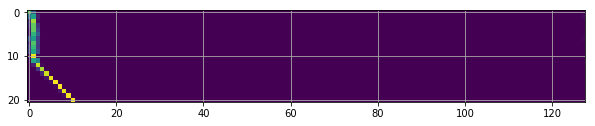

In [169]:
from pylab import *
for i in range(1, 100, 10):
    temp = np.asarray(aaa[i])
    _, write, read = np.split(temp, [8,128+8], axis=1)
    figure(figsize=(10,10))
    imshow(read, interpolation='nearest')
    grid(True)
    show()

## Writes

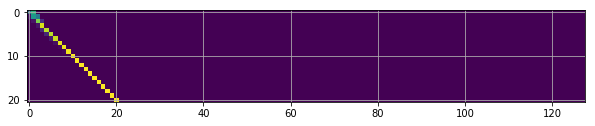

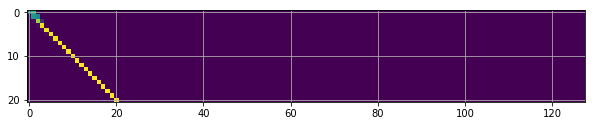

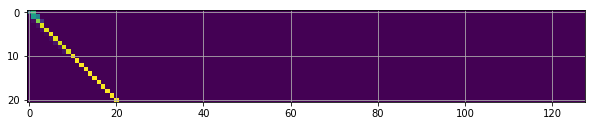

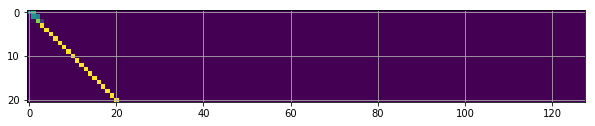

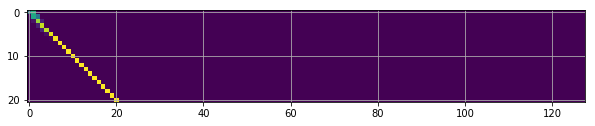

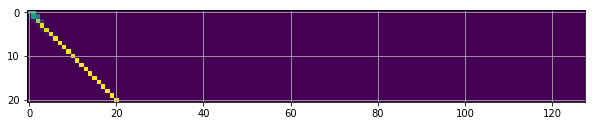

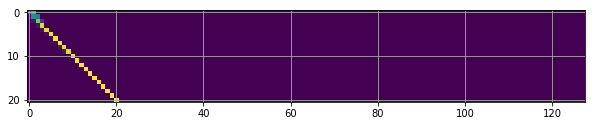

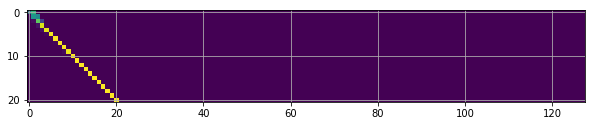

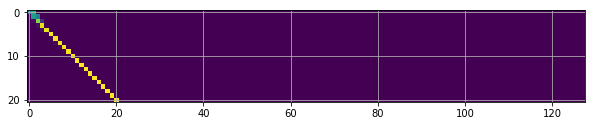

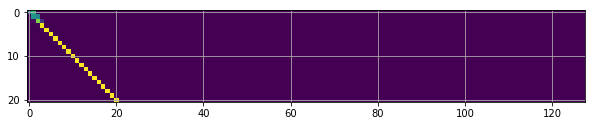

In [170]:
for i in range(1, 100, 10):
    temp = np.asarray(aaa[i])
    _, write, read = np.split(temp, [8,128+8], axis=1)
    figure(figsize=(10,10))
    imshow(write, interpolation='nearest')
    grid(True)
    show()

- These results make sense. For the write head, at each time step (new element of the sequence) he is writting in a different memory cell. That is why we obtain this nice diagonal. 
- For the reads, the first 10 time steps it is always reading from the first memory cell, because it is asked to output nothing, so the read actually doesnt matter much at that time. Then from time 10 to 20, he has to copy the sequence he read and stored into memory during the first 10 time steps. So he reads them one by one, hence the same diagonal as for the writes, but delayed by a number of time steps equal to the sequence length.

## Shift operator

The shift operator is a 1D convolution. But instead of padding when it reaches the boundaries of the input to be convolved with the kernel (the kernel being the shift vector), it goes back to the other side (if was at the begining, look for the end of the weight sequence, and if at the end, look for the begining of the weight vector).

In [ ]:
def _circulant(leng, n_shifts):

    """
    This will generate a tensor with `n_shifts` of rotated versions the
    identity matrix. When this tensor is multiplied by a vector
    the result are `n_shifts` shifted versions of that vector. Since
    everything is done with inner products, everything is differentiable.
    Paramters:
    ----------
    leng: int > 0, number of memory locations
    n_shifts: int > 0, number of allowed shifts (if 1, no shift)
    Returns:
    --------
    shift operation, a tensor with dimensions (n_shifts, leng, leng)
    """
    eye = np.eye(leng)
    shifts = range(n_shifts//2, -n_shifts//2, -1)
    C = np.asarray([np.roll(eye, s, axis=1) for s in shifts])
    return K.variable(C.astype(K.floatx()))